# Lab 8 - Recurrent Neural Networks

### Eric Smith and Jake Carlson

## Introduction
For this lab we will be examining questions and answers on the popular programming Q&A website, Stack Overflow. Stack Overflow allows programmers who are stuck on a problem ask the community about ways to resolve or circumvent said problem. This helps people write more accurate code faster. However, the community can be pretty hard on those who do not fully understand their question or are disrespectful. It could also be the case that the few developers who have experience with a problem similar to yours are not on the website when you post your question. If too much time passes, your post may be burried forever. This makes for some interesing questions. When should you make your post so that it has the highest chance of being answered? Are there specific keywords or phasing that encourage other programmers to answer your questions? Are there specific languages that have their questions answered faster than others? These are questions we will be exploring in this lab.

## Business Understanding

### Motivations
Stack Overflow is a go-to resource for developers. Questions are often distilled down to a single block of code that is easily digestible, and can be matched to the question you came to the site for. However, if you're truly stuck on something, it can seem like an eternity of waiting before someone responds to your question, and sometimes, it may not be answered at all. If you're working in industry and spending a lot of time waiting for a question to be answered, you could fall behind schedule and miss deadlines. These delays could cost your company a great deal in lost revenue and tech debt. Therefore, accurately predicting the amount of time to get a question answered can be seen as a valuable project management tool.

### Objectives
<!--
Original objective:

It would be useful if you could predict how quickly your question will be answered if you post it at various times through out the day. For a prediction tool like this to be useful, we want something that is 80-95% accurate in predicting when a question will be answered by. As a project manager, you want your developers to be asking questions that are concise and respectful. 
-->

Our main objective is to warn managers if a particular question will push back their deliverable date. For a prediction tool like this to be useful, we want to reduce the false negatives with respect to the questions that take the longest to answer. That is, if a question is going to take more than one day to answer, we must be able to catch that with near 100% accuracy.  

Furthermore, a tool that could recommend keywords to add to your post to make it more attractive, and provide you with approximate gains in time for reformatting, would also be a valuable project management tool.

### Evaluation
Because our prediction scenario involves deadlines, pure accuracy is not a sufficent way to measure the performance of our model. For example, if our model were to underestimate the time it takes to get a question answered, that could have potentially worse consequences for managers than to overestimate the cost. For this reason, we've decided to implement a custom cost function, which is broken down as follows:
<ul>
    <li>Predictions that are correct receive a tally of 1.</li>
    <li>An underestimation receives a tally of 0.25</li>
    <li>Severe underestimations receive a 0.1</li>
    <li>Overestimations receive a tally of 0.75</li>
</ul>

In [1]:
"""
Label legend
0: Less than 10 min
1: 10 min - 1 hour
2: 1 hour - 1 day
3: More than 1 day
"""

def custom_cost(y_true, y_pred):
    score = 0
    
    for i in range(len(y_pred)):
        # Correct: 1
        if y_true[i] == y_pred[i]:
            score += 1
        
        # Worst case scenario
        elif y_true[i] == 3 and y_pred[i] < y_true[i]:
            score += 0.1
        
        # the question will take longer than expected
        elif y_pred[i] < y_true[i]:
            score += 0.25
        
        # the question will take less than expected
        else:
            score += 0.75
        
    return score / len(y_pred)

## Data Understanding

Our data comes from the StackLite dataset from Kaggle<sup>1</sup>. The dataset covers StackOverflow questions from August 2008 to October 2016. We believe this timeframe would be an accurate representation of the types of coding questions that would be posted to StackOverflow today, as the questions may involve legacy code libraries and frameworks.


### Data Attributes
The following is a list of attributes in the data, their data types, and a brief description of the attribute.

#### Questions
- **Id** (nominal): A unique identifier for each question
- **OwnerUserId** (nominal): A unique identifier for the person who posted the question
- **CreationDate** (ordinal): A timestamp of when the question was posted
- **ClosedDate** (ordinal): A timestamp of when the question was closed, if the question wasn't closed this field is NaN
- **Score** (ratio): The number of upvotes a post has
- **Title** (text): A title for the question
- **Body** (text): The question body

#### Answers
- **Id** (nominal): A unique identifier for each answer
- **OwnerUserId** (nominal): A unique identifier for the person who posted the answer
- **CreationDate** (ordinal): A timestamp of when the answer was posted
- **ParentId** (nominal): The unique identifier of the question this answer is for
- **Score** (ratio): The number of upvotes an answer has
- **Body** (text): The answer body

#### Tags
- **Id** (nominal): The *Id* of the question the tag is associated with
- **Tag** (nominal): The tag a question has been assigned

## Data Quality
We will start working with the data set as is was cleaned in Lab 2. A number of attributes are not needed because they would not be known at the time a question is posted. We will be examining the question Title, Body, and Code block. We will include the question creation date and any tags associated with the question. Our questions data also has a duration value that records the number of minutes the question was up for before the accepted (or highest rated) answer was posted. We will discretize this value into four time ranges, Less than 10 minutes, 10 minutes to 1 hour, 1 hour to 1 day, and More than 1 day. The distribution of these classes is given below. We will also create a new column that contains all of the tags associated with each question, separated by spaces.

In [40]:
import pandas as pd
import numpy as np

df = pd.read_csv('../Lab2/clean-data/Questions.csv', index_col=0)
df_tags = pd.read_csv('../Lab2/clean-data/Tags.csv', index_col=0)

In [41]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Code,Duration
231906,8684820,1118172.0,2011-12-30T22:50:57Z,NaN,8,Scale HTML canvas to browser window size but d...,Is there a way to scale your HTML canvas to th...,NaN,414.433333
527250,18304620,1590705.0,2013-08-18T23:23:46Z,NaN,1,OrchardCMS Custom Forms and lookup fields,I can create custom form with Orchard Custom f...,NaN,567.750000
1096958,35749150,2726664.0,2016-03-02T13:53:23Z,NaN,0,Subtract working days from a date using Javasc...,I'd like to use a Javascript within my zapier....,NaN,6.716667
860951,28891250,2869332.0,2015-03-06T02:07:23Z,2015-03-06T04:49:50Z,0,Specifying Side Borders on Individual Cells in...,I've made a program for entering Sudoku puzzle...,NaN,NaN
221233,8326860,22693.0,2011-11-30T13:41:59Z,NaN,1,Wrapping any SQL Server 2008 statement with sk...,"Given any statement, I would like to wrap it ...",SELECTpublic override string WrapSelectSqlWith...,28.033333


In [42]:
import sys
from collections import Counter

# put the durations into different buckets, graph the result
# only count the durations that are not null
df_durations = pd.cut(df.Duration[ df.Duration.notnull() ], 
                      bins=[-1, 10, 60, 1440, sys.maxsize], 
                      labels=False)
# labels correspond to buckets of time above
labels = np.array(['Less than 10 min','10 min - 1 hour', '1 hour - 1 day', 'More than 1 day'])
df_durations = labels[df_durations]

duration_counts = Counter(df_durations) # count each occurance
df_durations

array(['1 hour - 1 day', '1 hour - 1 day', 'Less than 10 min', ...,
       '10 min - 1 hour', 'Less than 10 min', 'Less than 10 min'],
      dtype='<U16')

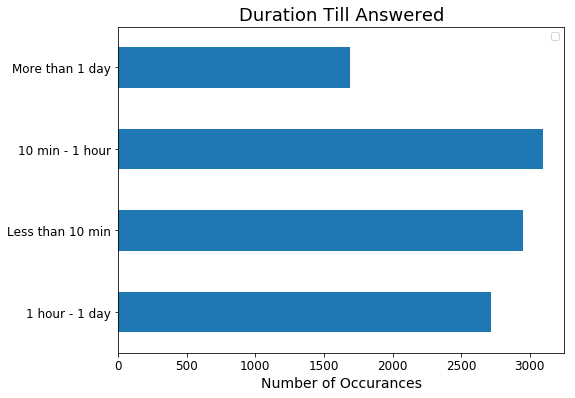

In [43]:
import matplotlib.pyplot as plt

df_duration_counts = pd.DataFrame.from_dict(duration_counts, orient='index')
df_duration_counts.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of Occurances', fontsize=14)
plt.title('Duration Till Answered', fontsize=18)
plt.legend([])
plt.show()

In [44]:
from datetime import datetime
from nltk.corpus import stopwords

feature_cols = ["CreationDate", "Title", "Body", "Code", "Duration"]
to_save = ["Id"] + feature_cols
df = df[to_save]
df = df[df.Duration.notnull()]
df.Duration = labels[pd.cut(df.Duration, 
                     bins=[-1, 10, 60, 1440, sys.maxsize], 
                     labels=False)]
ids = df.Id.unique()
df_tags = df_tags[df_tags.Id.isin(ids)]

# generate tags string for each question
tags_list = []
for i in df.Id.tolist():
    tags_list.append(" ".join(df_tags[df_tags.Id == i].astype(str).values[:,1]))

df = df.assign(Tags=tags_list)

# break creation date into an hour and weekday column
hour_list = [] # 0-23
day_list = [] # 0: Sunday, 1: Monday, 2: Tuesday, ...
fmt = '%Y-%m-%dT%H:%M:%SZ'
for d in df.CreationDate.tolist():
    dt = datetime.strptime(d, fmt)
    day_list.append(dt.isoweekday() if dt.isoweekday() != 7 else 0)
    hour_list.append(dt.hour)

df = df.assign(Hour=hour_list)
df = df.assign(Day=day_list)

# add boolean column indicating code
df = df.assign(HasCode=df.Code.notnull())

# remove stop words
stop = stopwords.words('english')
df.Title = df.Title.apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.Body = df.Body.apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

df.head()

,Id,CreationDate,Title,Body,Code,Duration,Tags,Hour,Day,HasCode
231906,8684820,2011-12-30T22:50:57Z,Scale HTML canvas browser window size don't sc...,Is way scale HTML canvas browser window width/...,NaN,1 hour - 1 day,html canvas html5-canvas,22,5,False
527250,18304620,2013-08-18T23:23:46Z,OrchardCMS Custom Forms lookup fields,I create custom form Orchard Custom forms Modu...,NaN,1 hour - 1 day,orchardcms,23,0,False
1096958,35749150,2016-03-02T13:53:23Z,Subtract working days date using Javascript,I'd like use Javascript within zapier.com-zap....,NaN,Less than 10 min,javascript date,13,3,False
221233,8326860,2011-11-30T13:41:59Z,Wrapping SQL Server 2008 statement skip/take o...,"Given statement, I would like wrap skip take o...",SELECTpublic override string WrapSelectSqlWith...,10 min - 1 hour,c# sql-server-2008 tsql,13,3,True
124225,5035840,2011-02-17T23:07:48Z,Lazy evaluation ostream C++ operators,I looking portable way implement lazy evaluati...,"void syslog(int priority, const char *format, ...",Less than 10 min,c++ logging iostream lazy-evaluation,23,4,True


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10459 entries, 231906 to 234393
Data columns (total 10 columns):
Id              10459 non-null int64
CreationDate    10459 non-null object
Title           10459 non-null object
Body            10459 non-null object
Code            7769 non-null object
Duration        10459 non-null object
Tags            10459 non-null object
Hour            10459 non-null int64
Day             10459 non-null int64
HasCode         10459 non-null bool
dtypes: bool(1), int64(3), object(6)
memory usage: 827.3+ KB


Our final data set has about 10,500 questions and 30,800 tags associated with those questions. We will save this data to disk for loading.

In [46]:
df.to_csv('./clean-data/questions.csv')

### Evaluation
We will use stratified 10-fold cross validation for evaluation of our networks. We will hold out 10% of our data as a validation set that will not be used in any of the 10-folds. This will allow us to gauge the generalization performance of our networks.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./clean-data/Questions.csv', index_col=0)

X = df.drop(["Duration", "Id"], axis=1)[df.Body.notnull()]

y = []
# encode y based off duration
for dur in df.Duration[df.Body.notnull()]:
    if dur == 'Less than 10 min':
        y.append(0)
    elif dur == '10 min - 1 hour':
        y.append(1)
    elif dur == '1 hour - 1 day':
        y.append(2)
    else:
        y.append(3)

y = np.asarray(y)

In [4]:
df.Title.to_csv('./clean-data/all_titles.txt', index=False)

In [55]:
X.head()

,CreationDate,Title,Body,Code,Tags,Hour,Day,HasCode
231906,2011-12-30T22:50:57Z,Scale HTML canvas browser window size don't sc...,Is way scale HTML canvas browser window width/...,NaN,html canvas html5-canvas,22,5,False
527250,2013-08-18T23:23:46Z,OrchardCMS Custom Forms lookup fields,I create custom form Orchard Custom forms Modu...,NaN,orchardcms,23,0,False
1096958,2016-03-02T13:53:23Z,Subtract working days date using Javascript,I'd like use Javascript within zapier.com-zap....,NaN,javascript date,13,3,False
221233,2011-11-30T13:41:59Z,Wrapping SQL Server 2008 statement skip/take o...,"Given statement, I would like wrap skip take o...",SELECTpublic override string WrapSelectSqlWith...,c# sql-server-2008 tsql,13,3,True
124225,2011-02-17T23:07:48Z,Lazy evaluation ostream C++ operators,I looking portable way implement lazy evaluati...,"void syslog(int priority, const char *format, ...",c++ logging iostream lazy-evaluation,23,4,True


In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical

NUM_CLASSES = 4

col_names = X.columns.values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=64)
for train_idx, test_idx in sss.split(X.values, y):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
    y_train, y_test = pd.DataFrame(y[train_idx], columns=["Duration"]), pd.DataFrame(y[test_idx], columns=["Duration"])

y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

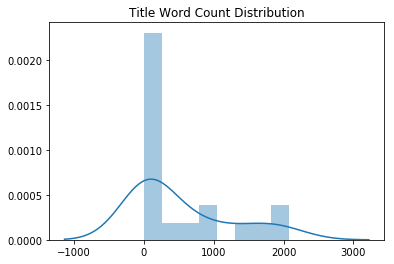

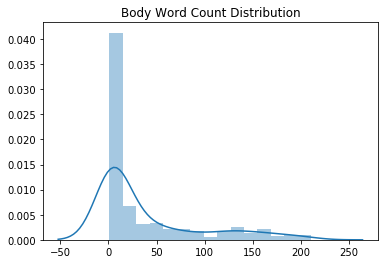

In [57]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

len_title_counts = Counter(df.Title.str.split().str.len())
df_title_len_counts = pd.DataFrame.from_dict(len_title_counts, orient='index')

sns.distplot(df_title_len_counts, bins=8)
plt.title('Title Word Count Distribution')
plt.show()

len_body_counts = Counter(df.Body.str.split().str.len())
df_body_len_counts = pd.DataFrame.from_dict(len_body_counts, orient='index')

sns.distplot(df_body_len_counts)
plt.title('Body Word Count Distribution')
plt.show()

1. Take the body of a question only
2. Truncate the body to 1000 words?
3. Convert each question to a 'real vector domain'
4. Pad each question with zeroes to use as embedding

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_body_length = 100 # maximum length of the question body
num_body_words = 5000 # top number of words to 'tokenize'
max_title_length = 50
num_title_words = 5000
num_tags = None
max_tag_words = 8

body_tokenizer = Tokenizer(num_words=num_body_words)
title_tokenizer = Tokenizer(num_words=num_title_words)
tag_tokenizer = Tokenizer(num_words=num_tags)

In [59]:
body_tokenizer.fit_on_texts(X_train.Body.values)
title_tokenizer.fit_on_texts(X_train.Title.values)
tag_tokenizer.fit_on_texts(X_train.Tags.values)

num_tags = len(tag_tokenizer.word_index) if num_tags==None else num_tags

X_train_body = body_tokenizer.texts_to_sequences(X_train.Body.values)
X_train_body = sequence.pad_sequences(X_train_body, maxlen=max_body_length)
X_train_title = title_tokenizer.texts_to_sequences(X_train.Title.values)
X_train_title = sequence.pad_sequences(X_train_title, maxlen=max_title_length)
X_train_tags = tag_tokenizer.texts_to_sequences(X_train.Tags.values)
X_train_tags = sequence.pad_sequences(X_train_tags, maxlen=max_tag_words)

X_test_body = body_tokenizer.texts_to_sequences(X_test.Body.values)
X_test_body = sequence.pad_sequences(X_test_body, maxlen=max_body_length)
X_test_title = title_tokenizer.texts_to_sequences(X_test.Title.values)
X_test_title = sequence.pad_sequences(X_test_title, maxlen=max_title_length)
X_test_tags = tag_tokenizer.texts_to_sequences(X_test.Tags.values)
X_test_tags = sequence.pad_sequences(X_test_tags, maxlen=max_tag_words)

In [60]:
print(type(X_train_body))
print(X_train_body.shape)
print(type(X_train_title))
print(X_train_title.shape)
print(type(X_train_tags))
print(X_train_tags.shape)

X_train_final = [X_train_body, X_train_title, X_train_tags]
X_test_final = [X_test_body, X_test_title, X_test_tags]

<class 'numpy.ndarray'>
(9405, 100)
<class 'numpy.ndarray'>
(9405, 50)
<class 'numpy.ndarray'>
(9405, 8)


## Modeling
We will examine two different recurrent network architectures. In the first, we will examine a Long Short Term Memory architecture in the first network and a Gated Recurrent Unit architecture in the second.

In [75]:
import numpy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, concatenate
from keras.layers import GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [78]:
crossed_cols = [['Hour', 'Day']]

embedding_size = 32

def build_rnn1():
    body_input = Input(shape=(X_train_body.shape[1],), name='body_input')
    body_embedding = Embedding(num_body_words, embedding_size,
                               input_length=max_body_length,
                               name='body_embedding')(body_input)

    title_input = Input(shape=(X_train_title.shape[1],), name='title_input')
    title_embedding = Embedding(num_title_words, embedding_size,
                                input_length=max_title_length,
                                name='title_embedding')(title_input)

    tag_input = Input(shape=(X_train_tags.shape[1],), name='tag_input')
    tag_embedding = Embedding(num_tags + 1, embedding_size,
                              input_length=max_tag_words,
                              name='tag_embedding')(tag_input)

    body_x = LSTM(50, dropout=0.2, recurrent_dropout=0.2,
                  name='body_lstm')(body_embedding)
    # body_x = LSTM(24, dropout=0.2, recurrent_dropout=0.2,
    #               name='body_lstm_2')(body_x)
    body_x = Dense(20, activation='relu', name='body_dense')(body_x)

    title_x = LSTM(40, dropout=0.2, recurrent_dropout=0.2,
                   name='title_lstm')(title_embedding)
    title_x = Dense(16, activation='relu', name='title_dense')(title_x)

    tag_x = LSTM(10, dropout=0.2, recurrent_dropout=0.2,
                 name='tag_lstm')(tag_embedding)
    tag_x = Dense(4, activation='relu', name='tag_dense')(tag_x)


    time_input = None
    time_x = None
    for cols in crossed_cols:
        enc = LabelEncoder()

        X_crossed_train = X_train[cols].apply(lambda x: '_'.join([str(s) for s in x]), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join([str(s) for s in x]), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)

        N = max(X_crossed_train+1)
        time_input = Input(shape=(1,),dtype='int32', name='time_input')
        time_x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name='time_embedding')(time_input)
        time_x = Flatten()(time_x)
        time_x = Dense(32, activation='relu', name='time_dense')(time_x)

    has_code_input = Input(shape=(1,), name='has_code_input')
    has_code_x = Dense(2, activation='relu', name='has_code_dense')(has_code_input)

    x = concatenate([body_x, title_x, tag_x, time_x, has_code_x])
    x = Dense(32, activation='relu', name='all_dense')(x)
    x = Dense(16, activation='relu', name='all_dense_2')(x)
    x = Dense(NUM_CLASSES, activation='sigmoid', name='output')(x)

    model_1 = Model(inputs=[body_input, title_input, tag_input, time_input, has_code_input], outputs=x)
    model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_1

model_1 = build_rnn1()
print(model_1.summary())


scores_1 = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = [X_train_body[train_idx], X_train_title[train_idx], X_train_tags[train_idx]]+[X_crossed_train[train_idx]]+[X_train['HasCode'].values[train_idx]]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = [X_train_body[test_idx], X_train_title[test_idx], X_train_tags[test_idx]]+[X_crossed_train[test_idx]]+[X_train['HasCode'].values[test_idx]]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)

    model_1 = build_rnn1()
    
    model_1.fit(X_train_temp, y_train_temp,
                validation_data=(X_test_temp, y_test_temp),
                epochs=3, batch_size=64)
    
    cost = custom_cost(np.argmax(y_test_temp, axis=1), np.argmax(model_1.predict(X_test_temp), axis=1))
    print("Cost:", cost)
    scores_1.append(cost)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
body_input (InputLayer)          (None, 100)           0                                            
____________________________________________________________________________________________________
title_input (InputLayer)         (None, 50)            0                                            
____________________________________________________________________________________________________
tag_input (InputLayer)           (None, 8)             0                                            
____________________________________________________________________________________________________
time_input (InputLayer)          (None, 1)             0                                            
___________________________________________________________________________________________

In [79]:
model_1 = build_rnn1()
model_1.fit(X_train_final+[X_crossed_train]+[X_train['HasCode'].values], y_train_ohe,
            validation_data=(X_test_final+[X_crossed_test]+[X_test['HasCode'].values], y_test_ohe),
            epochs=3, batch_size=64)

cost = custom_cost(y_test, np.argmax(model_1.predict(X_test_final+[X_crossed_test]+[X_test['HasCode'].values]), axis=1))
print("Cost:", cost)

Train on 9405 samples, validate on 1046 samples
Epoch 1/3
9405/9405 [==============================] - 60s - loss: 1.3592 - acc: 0.2976 - val_loss: 1.3446 - val_acc: 0.3528
Epoch 2/3
9405/9405 [==============================] - 51s - loss: 1.2656 - acc: 0.3847 - val_loss: 1.2645 - val_acc: 0.3891
Epoch 3/3
9405/9405 [==============================] - 49s - loss: 1.1003 - acc: 0.4745 - val_loss: 1.3341 - val_acc: 0.3815
Cost: 0.6192160611854705


In [80]:
from sklearn import metrics as mt

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    plt.show()

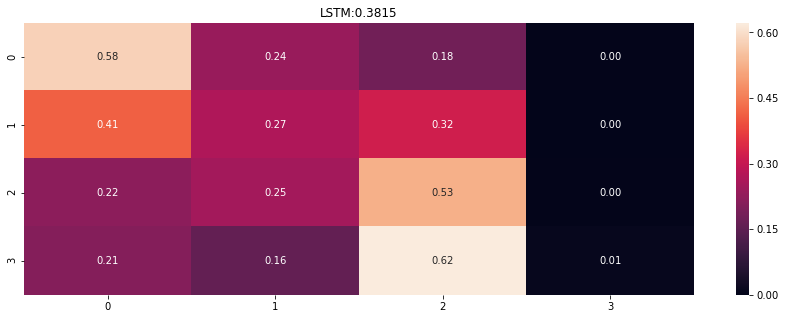

In [81]:
summarize_net(model_1, X_test_final+[X_crossed_test]+[X_test['HasCode'].values], y_test, title_text='LSTM:')

In [82]:
crossed_cols = [['Hour', 'Day']]

embedding_size = 32

def build_rnn2():
    body_input = Input(shape=(X_train_body.shape[1],), name='body_input')
    body_embedding = Embedding(num_body_words, embedding_size,
                               input_length=max_body_length,
                               name='body_embedding')(body_input)

    title_input = Input(shape=(X_train_title.shape[1],), name='title_input')
    title_embedding = Embedding(num_title_words, embedding_size,
                                input_length=max_title_length,
                                name='title_embedding')(title_input)

    tag_input = Input(shape=(X_train_tags.shape[1],), name='tag_input')
    tag_embedding = Embedding(num_tags + 1, embedding_size,
                              input_length=max_tag_words,
                              name='tag_embedding')(tag_input)

    body_x = GRU(50, dropout=0.2, recurrent_dropout=0.2,
                  name='body_gru')(body_embedding)
    body_x = Dense(20, activation='relu', name='body_dense')(body_x)

    title_x = GRU(40, dropout=0.2, recurrent_dropout=0.2,
                   name='title_gru')(title_embedding)
    title_x = Dense(16, activation='relu', name='title_dense')(title_x)

    tag_x = GRU(10, dropout=0.2, recurrent_dropout=0.2,
                 name='tag_gru')(tag_embedding)
    tag_x = Dense(8, activation='relu', name='tag_dense')(tag_x)


    time_input = None
    time_x = None
    for cols in crossed_cols:
        enc = LabelEncoder()

        X_crossed_train = X_train[cols].apply(lambda x: '_'.join([str(s) for s in x]), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join([str(s) for s in x]), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)

        N = max(X_crossed_train+1)
        time_input = Input(shape=(1,),dtype='int32', name='time_input')
        time_x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name='time_embedding')(time_input)
        time_x = Flatten()(time_x)
        time_x = Dense(32, activation='relu', name='time_dense')(time_x)

    has_code_input = Input(shape=(1,), name='has_code_input')
    has_code_x = Dense(2, activation='relu', name='has_code_dense')(has_code_input)

    x = concatenate([body_x, title_x, tag_x, time_x, has_code_x])
    x = Dense(32, activation='relu', name='all_dense')(x)
    x = Dense(16, activation='relu', name='all_dense_2')(x)
    x = Dense(NUM_CLASSES, activation='sigmoid', name='output')(x)

    model_2 = Model(inputs=[body_input, title_input, tag_input, time_input, has_code_input], outputs=x)
    model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_2

model_2 = build_rnn2()
print(model_2.summary())

scores_2 = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = [X_train_body[train_idx], X_train_title[train_idx], X_train_tags[train_idx]]+[X_crossed_train[train_idx]]+[X_train['HasCode'].values[train_idx]]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = [X_train_body[test_idx], X_train_title[test_idx], X_train_tags[test_idx]]+[X_crossed_train[test_idx]]+[X_train['HasCode'].values[test_idx]]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)

    model_2 = build_rnn1()
    
    model_2.fit(X_train_temp, y_train_temp,
                validation_data=(X_test_temp, y_test_temp),
                epochs=3, batch_size=64)
    
    cost = custom_cost(np.argmax(y_test_temp, axis=1), np.argmax(model_2.predict(X_test_temp), axis=1))
    print("Cost:", cost)
    scores_2.append(cost)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
body_input (InputLayer)          (None, 100)           0                                            
____________________________________________________________________________________________________
title_input (InputLayer)         (None, 50)            0                                            
____________________________________________________________________________________________________
tag_input (InputLayer)           (None, 8)             0                                            
____________________________________________________________________________________________________
time_input (InputLayer)          (None, 1)             0                                            
___________________________________________________________________________________________

In [83]:
model_2 = build_rnn2()
model_2.fit(X_train_final+[X_crossed_train]+[X_train['HasCode'].values], y_train_ohe,
            validation_data=(X_test_final+[X_crossed_test]+[X_test['HasCode'].values], y_test_ohe),
            epochs=3, batch_size=64)

cost = custom_cost(y_test, np.argmax(model_2.predict(X_test_final+[X_crossed_test]+[X_test['HasCode'].values]), axis=1))
print("Cost:", cost)

Train on 9405 samples, validate on 1046 samples
Epoch 1/3
9405/9405 [==============================] - 45s - loss: 1.3670 - acc: 0.2766 - val_loss: 1.3357 - val_acc: 0.3011
Epoch 2/3
9405/9405 [==============================] - 38s - loss: 1.2451 - acc: 0.4021 - val_loss: 1.2805 - val_acc: 0.3872
Epoch 3/3
9405/9405 [==============================] - 38s - loss: 1.0672 - acc: 0.5189 - val_loss: 1.3698 - val_acc: 0.3728
Cost: 0.631835564053539


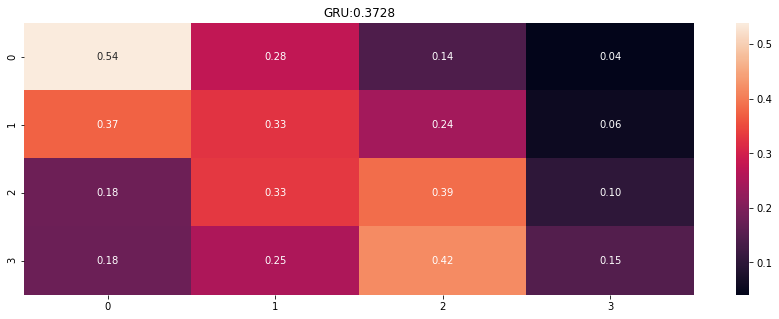

In [84]:
summarize_net(model_2, X_test_final+[X_crossed_test]+[X_test['HasCode'].values], y_test, title_text='GRU:')

## References
1. <a href='https://www.kaggle.com/stackoverflow/stacklite'>Kaggle StackLite data set</a>